**Домашнее задание к уроку 4.**

1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.).

In [ ]:
# Реализация критериев останова:
# 1) уровень вложенности равен максимальному (см. метод built_tree)
# 2) общее количество листов больше или равно максимальному (см. метод built_tree)

2. Для задачи классификации обучить дерево решений с использованием критериев разбиения Джини и Энтропия. Сравнить качество классификации, сделать выводы.

In [ ]:
# Реализация критериев разбиения Джини, Энтропия и дополнительно ошибки классификации:
# 1) созданы методы: entropy, missclass;
# 2) изменены методы: quality, find_best_split

3. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [ ]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [ ]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_samples = 1000, n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

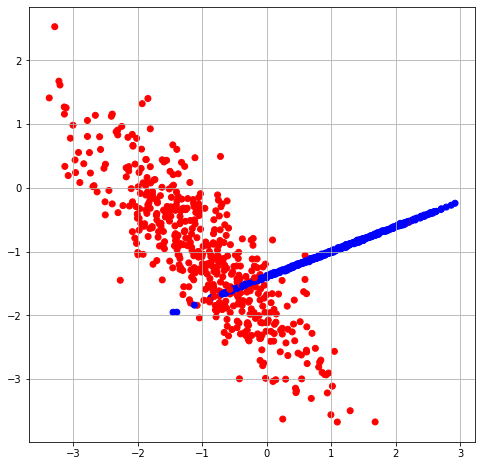

In [ ]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)
plt.grid(True)

In [ ]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [ ]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [ ]:
# Расчет критерия для регрессии - дисперсия

def var(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    P = []
    for label in classes:
        p = classes[label] / len(labels)
        P.append(p)
    var = np.array(P).var()

    return var

In [ ]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [ ]:
# Расчет критерия энтропии Шеннона 

def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    for label in classes:
        p = classes[label] / len(labels)
        entropy = - (p * np.log2(p))
        
    return entropy

In [ ]:
# Расчет критерия ошибки классификации (misclassification error) 

def missclass(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    P = []
    for label in classes:
        p = classes[label] / len(labels)
        P.append(p)
    missclass_err = 1 - max(P)
        
    return missclass_err

In [ ]:
# Расчет качества

def quality(left_labels, right_labels, prev_quality, type_quality = 0):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    if type_quality == 0:
        return prev_quality - p * gini(left_labels) - (1 - p) * gini(right_labels)
    elif type_quality == 1:
        return prev_quality - p * entropy(left_labels) - (1 - p) * entropy(right_labels)
    elif type_quality == 2:
        return prev_quality - p * missclass(left_labels) - (1 - p) * missclass(right_labels)
    else:
        return prev_quality - p * var(left_labels) - (1 - p) * var(right_labels)

In [ ]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)

    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [ ]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, type_quality = 0):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    if type_quality == 0:
        prev_quality = gini(labels)
    elif type_quality == 1:
        prev_quality = entropy(labels)
    elif type_quality == 2:
        prev_quality = missclass(labels)
    else:
        prev_quality = var(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, prev_quality, type_quality)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [ ]:
# Построение дерева с помощью рекурсивной функции
# Согласно задания 1 реализован критерий останова (количество листьев, количество используемых признаков, глубина дерева)

def build_tree(data, labels, tree_level = 1, type_quality = 0, max_tree_level = 10, max_leaf_count = 20):

    global leaf_count

    quality, t, index = find_best_split(data, labels, type_quality)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества,
    #  Или когда уровень вложенности равен максимальному,
    #  Или когда общее количество листов больше или равно максимальному
    if quality == 0 or tree_level == max_tree_level or leaf_count >= max_leaf_count:
        leaf_count += 1
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    tree_level += 1

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, tree_level)
    false_branch = build_tree(false_data, false_labels, tree_level)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [ ]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [ ]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [ ]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [ ]:
# Построим дерево по обучающей выборке с критерием качества разбиения неопределенности Джини (для классицикации)

# Текущее значение общего количества листов
leaf_count = 0

my_tree0 = build_tree(train_data, train_labels, 1, type_quality = 0)
# my_tree0 = Leaf([0], [1])

# Текущее значение общего количества листов
leaf_count = 0

# Построим дерево по обучающей выборке с критерием качества разбиения энтропией Шеннона (для классицикации)
my_tree1 = build_tree(train_data, train_labels, 1, type_quality = 1)

# Текущее значение общего количества листов
leaf_count = 0

# Построим дерево по обучающей выборке с критерием качества разбиения ошибкой классификации (для классицикации)
my_tree2 = build_tree(train_data, train_labels, 1, type_quality = 2)

# Текущее значение общего количества листов
leaf_count = 0

# Построим дерево по обучающей выборке с критерием качества разбиения дисперсией (для регрессии)
my_tree3 = build_tree(train_data, train_labels, 1, type_quality = 3)

In [ ]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    

In [ ]:
# Напечатаем ход нашего дерева с критерием качества разбиения неопределенности Джини
print_tree(my_tree0)

Индекс 0
Порог -0.001967524769128759
--> True:
  Индекс 1
  Порог -1.3993975578815423
  --> True:
    Индекс 1
    Порог -1.6646404646216442
    --> True:
      Индекс 0
      Порог -0.8728986138474495
      --> True:
        Прогноз: 0
      --> False:
        Прогноз: 0
    --> False:
      Индекс 0
      Порог -0.6882680999463433
      --> True:
        Прогноз: 0
      --> False:
        Индекс 0
        Порог -0.40118216125291906
        --> True:
          Индекс 1
          Порог -1.568473711740985
          --> True:
            Индекс 0
            Порог -0.5543283463967665
            --> True:
              Прогноз: 1
            --> False:
              Прогноз: 1
          --> False:
            Прогноз: 0
        --> False:
          Индекс 1
          Порог -1.5264301097909836
          --> True:
            Прогноз: 1
          --> False:
            Индекс 1
            Порог -1.4255078037225668
            --> True:
              Прогноз: 1
            --> False:
    

In [ ]:
# Напечатаем ход нашего дерева с критерием качества разбиения энтропией Шеннона
print_tree(my_tree1)

Индекс 0
Порог 0.8196871738973301
--> True:
  Индекс 0
  Порог -0.001967524769128759
  --> True:
    Индекс 1
    Порог -1.3993975578815423
    --> True:
      Индекс 1
      Порог -1.6646404646216442
      --> True:
        Индекс 0
        Порог -0.8728986138474495
        --> True:
          Прогноз: 0
        --> False:
          Прогноз: 0
      --> False:
        Индекс 0
        Порог -0.6882680999463433
        --> True:
          Прогноз: 0
        --> False:
          Индекс 0
          Порог -0.40118216125291906
          --> True:
            Индекс 1
            Порог -1.568473711740985
            --> True:
              Индекс 0
              Порог -0.5543283463967665
              --> True:
                Прогноз: 1
              --> False:
                Прогноз: 1
            --> False:
              Прогноз: 0
          --> False:
            Индекс 1
            Порог -1.5264301097909836
            --> True:
              Прогноз: 1
            --> False:
       

In [ ]:
# Напечатаем ход нашего дерева с критерием качества разбиения ошибкой классификации
print_tree(my_tree2)

Индекс 0
Порог -0.001967524769128759
--> True:
  Индекс 1
  Порог -1.3993975578815423
  --> True:
    Индекс 1
    Порог -1.6646404646216442
    --> True:
      Индекс 0
      Порог -0.8728986138474495
      --> True:
        Прогноз: 0
      --> False:
        Прогноз: 0
    --> False:
      Индекс 0
      Порог -0.6882680999463433
      --> True:
        Прогноз: 0
      --> False:
        Индекс 0
        Порог -0.40118216125291906
        --> True:
          Индекс 1
          Порог -1.568473711740985
          --> True:
            Индекс 0
            Порог -0.5543283463967665
            --> True:
              Прогноз: 1
            --> False:
              Прогноз: 1
          --> False:
            Прогноз: 0
        --> False:
          Индекс 1
          Порог -1.5264301097909836
          --> True:
            Прогноз: 1
          --> False:
            Индекс 1
            Порог -1.4255078037225668
            --> True:
              Прогноз: 1
            --> False:
    

In [ ]:
# Напечатаем ход нашего дерева с критерием качества разбиения дисперсией (для регрессии)
print_tree(my_tree3)

Индекс 0
Порог 2.2821745740026316
--> True:
  Индекс 0
  Порог -0.001967524769128759
  --> True:
    Индекс 1
    Порог -1.3993975578815423
    --> True:
      Индекс 1
      Порог -1.6646404646216442
      --> True:
        Индекс 0
        Порог -0.8728986138474495
        --> True:
          Прогноз: 0
        --> False:
          Прогноз: 0
      --> False:
        Индекс 0
        Порог -0.6882680999463433
        --> True:
          Прогноз: 0
        --> False:
          Индекс 0
          Порог -0.40118216125291906
          --> True:
            Индекс 1
            Порог -1.568473711740985
            --> True:
              Индекс 0
              Порог -0.5543283463967665
              --> True:
                Прогноз: 1
              --> False:
                Прогноз: 1
            --> False:
              Прогноз: 0
          --> False:
            Индекс 1
            Порог -1.5264301097909836
            --> True:
              Прогноз: 1
            --> False:
       

In [ ]:
# Получим ответы для обучающей выборки с критерием качества разбиения неопределенности Джини
train_answers0 = predict(train_data, my_tree0)

# np.array(train_answers).T,labels

In [ ]:
# Получим ответы для обучающей выборки с критерием качества разбиения энтропией Шеннона
train_answers1 = predict(train_data, my_tree1)

# np.array(train_answers).T,labels

In [ ]:
# Получим ответы для обучающей выборки с критерием качества разбиения ошибкой классификации
train_answers2 = predict(train_data, my_tree2)

# np.array(train_answers).T,labels

In [ ]:
# Получим ответы для обучающей выборки с критерием качества разбиения дисперсией (для регрессии)
train_answers3 = predict(train_data, my_tree3)

# np.array(train_answers).T,labels

In [ ]:
# Получим ответы для тестовой выборки с критерием качества разбиения неопределенности Джини
answers0 = predict(test_data, my_tree0)

# np.array(test_labels).T,labels

In [ ]:
# Получим ответы для тестовой выборки с критерием качества разбиения энтропией Шеннона
answers1 = predict(test_data, my_tree1)

# np.array(test_labels).T,labels

In [ ]:
# Получим ответы для тестовой выборки с критерием качества разбиения ошибкой классификации
answers2 = predict(test_data, my_tree2)

# np.array(test_labels).T,labels

In [ ]:
# Получим ответы для тестовой выборки с критерием качества разбиения дисперсией (для регрессии)
answers3 = predict(test_data, my_tree3)

# np.array(test_labels).T,labels

In [ ]:
# Метод получения метрик качества
# Нужен подключенный Numpy as np: import numpy as np
def quality_metrics(y_true, y_predict, get_metrics = '*', bin_threshold = 0.5):
    # get_metrics = '*' - получение всех метрик: accuracy, matrix_errors, precision, recall, F_score
    # get_metrics = 'a'/'accuracy' - получение accuracy
    # get_metrics = 'm'/'matrix_errors' - получение matrix_errors
    # get_metrics = 'p'/'precision' - получение precision
    # get_metrics = 'r'/'recall' - получение recall
    # get_metrics = 'f'/'f_score' - получение f_score
    # get_metrics = 'tp' - получение TP
    # get_metrics = 'tn' - получение TN
    # get_metrics = 'fn' - получение FN
    # get_metrics = 'fp' - получение FP

    metrics = {}
    y = np.array(y_true)
    y_pred = np.array(y_predict)

    TP = ((y > bin_threshold) & (y_pred > bin_threshold)).sum()
    TN = ((y <= bin_threshold) & (y_pred <= bin_threshold)).sum()
    FN = ((y > bin_threshold) & (y_pred <= bin_threshold)).sum()
    FP = ((y <= bin_threshold) & (y_pred > bin_threshold)).sum()

    # accuracy - доля правильных ответов
    accuracy = (TP + TN) / y.shape[0]

    # матрица ошибок
    matrix_errors = np.array([[TP, FP],[FN, TN]])

    # precision
    precision = TP / (TP + FP)

    # recall
    recall = TP / (TP + FN)

    # recall
    f_score =  2 * precision * recall / (precision + recall)

    for m in get_metrics.split(','):
        m = m.strip()
        if m == '*':
            metrics['accuracy'] = accuracy
            metrics['matrix_errors'] = matrix_errors
            metrics['precision'] = precision
            metrics['recall'] = recall
            metrics['f_score'] = f_score
            break
        elif m == 'a' or m == 'accuracy':
            metrics['accuracy'] = accuracy
        elif m == 'm' or m == 'matrix_errors':
            metrics['matrix_errors'] = matrix_errors
        elif m == 'p' or m == 'precision':
            metrics['precision'] = precision
        elif m == 'r' or m == 'recall':
            metrics['recall'] = recall
        elif m == 'f' or m == 'f_score':
            metrics['f_score'] = f_score
        elif m == 'tp':
            metrics['TP'] = TP
        elif m == 'tn':
            metrics['TN'] = TN
        elif m == 'fn':
            metrics['FN'] = FN
        elif m == 'fp':
            metrics['FP'] = FP

    return metrics

In [ ]:
# Точность на обучающей выборке с критерием качества разбиения неопределенности Джини
train_metrics0 = quality_metrics(train_labels, train_answers0)

print("Точность на обучающей выборке с критерием качества разбиения неопределенности Джини")
print(f"accuracy={train_metrics0['accuracy']:.3f}")
print(f"matrix_errors:\n{train_metrics0['matrix_errors']}")
print(f"precision={train_metrics0['precision']:.3f}")
print(f"recall={train_metrics0['recall']:.3f}")
print(f"F_score={train_metrics0['f_score']:.3f}")

# Точность на тестовой выборке с критерием качества разбиения неопределенности Джини
metrics0 = quality_metrics(test_labels, answers0)

print("\nТочность на тестовой выборке с критерием качества разбиения неопределенности Джини")
print(f"accuracy={metrics0['accuracy']:.3f}")
print(f"matrix_errors:\n{metrics0['matrix_errors']}")
print(f"precision={metrics0['precision']:.3f}")
print(f"recall={metrics0['recall']:.3f}")
print(f"F_score={metrics0['f_score']:.3f}")

Точность на обучающей выборке с критерием качества разбиения неопределенности Джини
accuracy=0.981
matrix_errors:
[[359  10]
 [  3 328]]
precision=0.973
recall=0.992
F_score=0.982

Точность на тестовой выборке с критерием качества разбиения неопределенности Джини
accuracy=0.950
matrix_errors:
[[132  11]
 [  4 153]]
precision=0.923
recall=0.971
F_score=0.946


In [ ]:
# Точность на обучающей выборке с критерием качества разбиения энтропией Шеннона
train_metrics1 = quality_metrics(train_labels, train_answers1)

print("Точность на обучающей выборке с критерием качества разбиения энтропией Шеннона")
print(f"accuracy={train_metrics1['accuracy']:.3f}")
print(f"matrix_errors:\n{train_metrics1['matrix_errors']}")
print(f"precision={train_metrics1['precision']:.3f}")
print(f"recall={train_metrics1['recall']:.3f}")
print(f"F_score={train_metrics1['f_score']:.3f}")

# Точность на тестовой выборке с критерием качества разбиения энтропией Шеннона
metrics1 = quality_metrics(test_labels, answers1)

print("\nТочность на тестовой выборке с критерием качества разбиения энтропией Шеннона")
print(f"accuracy={metrics1['accuracy']:.3f}")
print(f"matrix_errors:\n{metrics1['matrix_errors']}")
print(f"precision={metrics1['precision']:.3f}")
print(f"recall={metrics1['recall']:.3f}")
print(f"F_score={metrics1['f_score']:.3f}")

Точность на обучающей выборке с критерием качества разбиения энтропией Шеннона
accuracy=0.981
matrix_errors:
[[359  10]
 [  3 328]]
precision=0.973
recall=0.992
F_score=0.982

Точность на тестовой выборке с критерием качества разбиения энтропией Шеннона
accuracy=0.950
matrix_errors:
[[132  11]
 [  4 153]]
precision=0.923
recall=0.971
F_score=0.946


In [ ]:
# Точность на обучающей выборке с критерием качества разбиения ошибкой классификации
train_metrics2 = quality_metrics(train_labels, train_answers2)

print("Точность на обучающей выборке с критерием качества разбиения ошибкой классификации")
print(f"accuracy={train_metrics2['accuracy']:.3f}")
print(f"matrix_errors:\n{train_metrics2['matrix_errors']}")
print(f"precision={train_metrics2['precision']:.3f}")
print(f"recall={train_metrics2['recall']:.3f}")
print(f"F_score={train_metrics2['f_score']:.3f}")

# Точность на тестовой выборке с критерием качества разбиения ошибкой классификации
metrics2 = quality_metrics(test_labels, answers2)

print("\nТочность на тестовой выборке с критерием качества разбиения ошибкой классификации")
print(f"accuracy={metrics2['accuracy']:.3f}")
print(f"matrix_errors:\n{metrics2['matrix_errors']}")
print(f"precision={metrics2['precision']:.3f}")
print(f"recall={metrics2['recall']:.3f}")
print(f"F_score={metrics2['f_score']:.3f}")

Точность на обучающей выборке с критерием качества разбиения ошибкой классификации
accuracy=0.981
matrix_errors:
[[359  10]
 [  3 328]]
precision=0.973
recall=0.992
F_score=0.982

Точность на тестовой выборке с критерием качества разбиения ошибкой классификации
accuracy=0.950
matrix_errors:
[[132  11]
 [  4 153]]
precision=0.923
recall=0.971
F_score=0.946


In [ ]:
# Точность на обучающей выборке с критерием качества разбиения дисперсией (для регрессии)
train_metrics3 = quality_metrics(train_labels, train_answers3)

print("Точность на обучающей выборке с критерием качества разбиения дисперсией (для регрессии)")
print(f"accuracy={train_metrics3['accuracy']:.3f}")
print(f"matrix_errors:\n{train_metrics3['matrix_errors']}")
print(f"precision={train_metrics3['precision']:.3f}")
print(f"recall={train_metrics3['recall']:.3f}")
print(f"F_score={train_metrics3['f_score']:.3f}")

# Точность на тестовой выборке с критерием качества разбиения дисперсией (для регрессии)
metrics3 = quality_metrics(test_labels, answers3)

print("\nТочность на тестовой выборке с критерием качества разбиения дисперсией (для регрессии)")
print(f"accuracy={metrics3['accuracy']:.3f}")
print(f"matrix_errors:\n{metrics3['matrix_errors']}")
print(f"precision={metrics3['precision']:.3f}")
print(f"recall={metrics3['recall']:.3f}")
print(f"F_score={metrics3['f_score']:.3f}")

Точность на обучающей выборке с критерием качества разбиения дисперсией (для регрессии)
accuracy=0.981
matrix_errors:
[[359  10]
 [  3 328]]
precision=0.973
recall=0.992
F_score=0.982

Точность на тестовой выборке с критерием качества разбиения дисперсией (для регрессии)
accuracy=0.950
matrix_errors:
[[132  11]
 [  4 153]]
precision=0.923
recall=0.971
F_score=0.946


Text(0.5, 1.0, 'Gini impurity. Test accuracy=0.95')

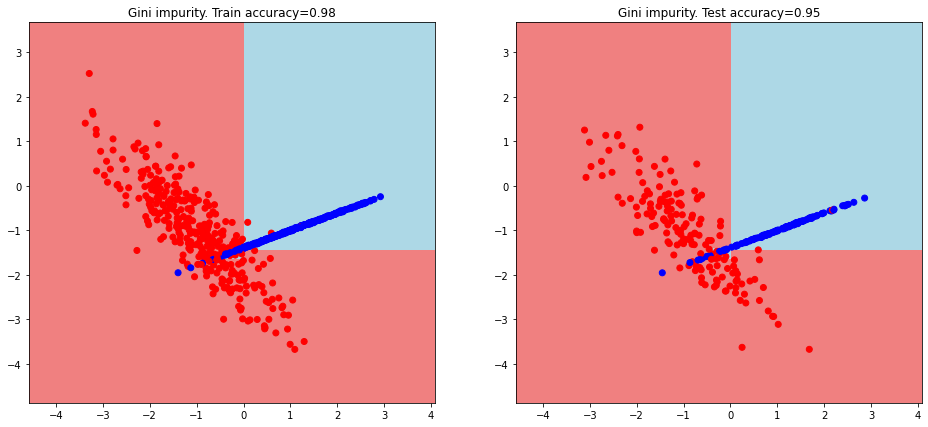

In [ ]:
# Визуализируем дерево на графике с критерием качества разбиения неопределенности Джини

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки с критерием качества разбиения неопределенности Джини
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree0)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f"Gini impurity. Train accuracy={train_metrics0['accuracy']:.2f}")

# график тестовой выборки с критерием качества разбиения неопределенности Джини
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f"Gini impurity. Test accuracy={metrics0['accuracy']:.2f}")

Text(0.5, 1.0, 'Shannon Entropy. Test accuracy=0.95')

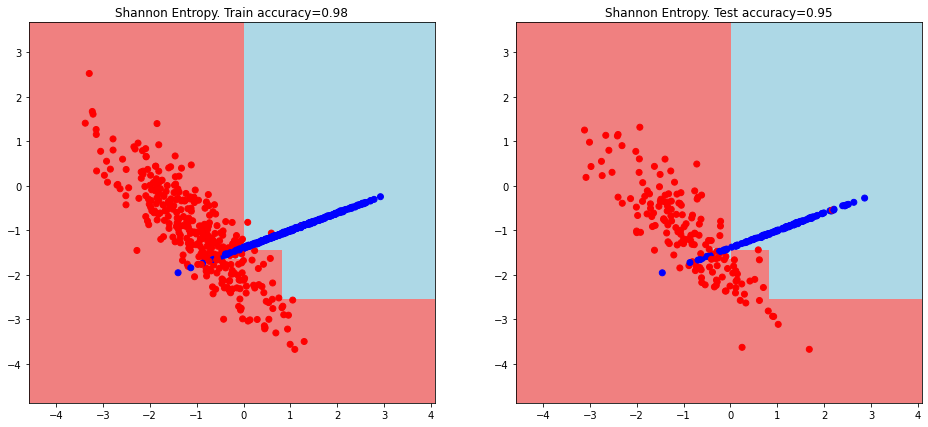

In [ ]:
# Визуализируем дерево на графике с критерием качества разбиения энтропией Шеннона

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки с критерием качества разбиения энтропией Шеннона
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree1)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f"Shannon Entropy. Train accuracy={train_metrics1['accuracy']:.2f}")

# график тестовой выборки с критерием качества разбиения энтропией Шеннона
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f"Shannon Entropy. Test accuracy={metrics1['accuracy']:.2f}")

Text(0.5, 1.0, 'Misclassification error. Test accuracy=0.95')

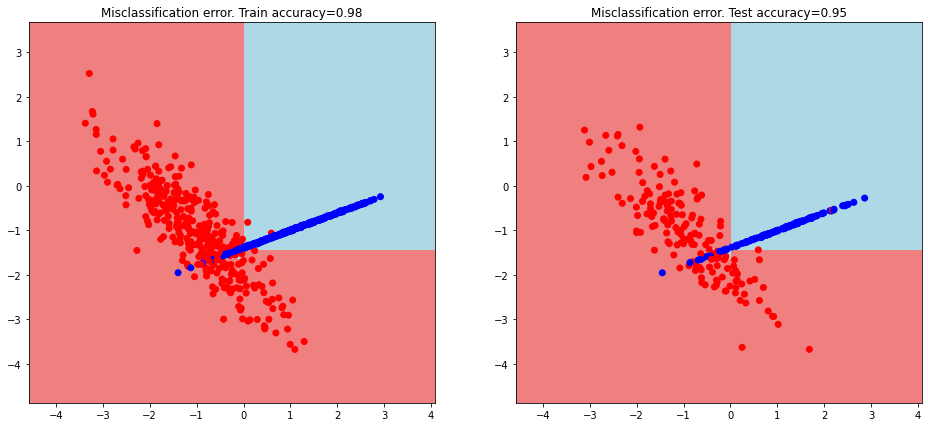

In [ ]:
# Визуализируем дерево на графике с критерием качества разбиения ошибкой классификации

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки с критерием качества разбиения ошибкой классификации
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree2)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f"Misclassification error. Train accuracy={train_metrics2['accuracy']:.2f}")

# график тестовой выборки с критерием качества разбиения ошибкой классификации
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f"Misclassification error. Test accuracy={metrics2['accuracy']:.2f}")

Text(0.5, 1.0, 'Regression Decision Tree. Test accuracy=0.95')

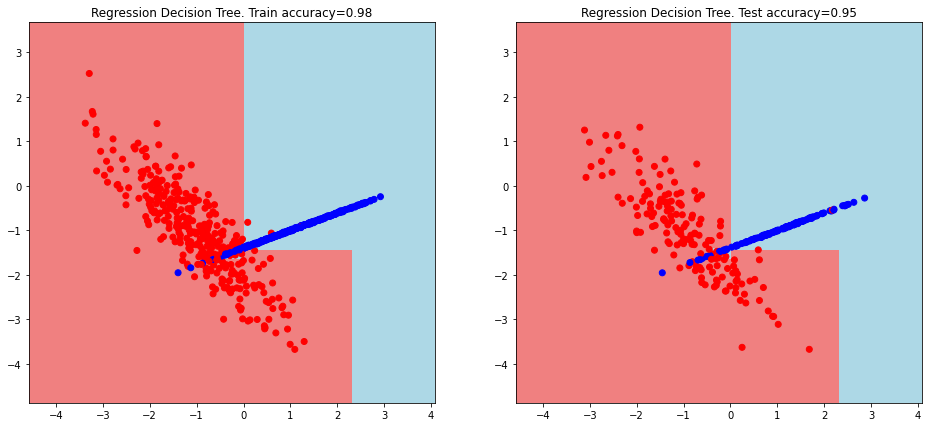

In [ ]:
# Визуализируем дерево на графике с критерием качества разбиения ошибкой классификации

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки с критерием качества разбиения ошибкой классификации
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree3)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f"Regression Decision Tree. Train accuracy={train_metrics3['accuracy']:.2f}")

# график тестовой выборки с критерием качества разбиения ошибкой классификации
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f"Regression Decision Tree. Test accuracy={metrics3['accuracy']:.2f}")

Для задачи классификации данных объемом 1000 с 2-мя признаками (бинарная классификация) получены деревья решений с использованием следующих критериев качества разбиения:
- Джини (accuracy: 98.14 (train_data)/95.00 (test_data));
- энтропии (accuracy: 98.14 (train_data)/95.00 (test_data));
- ошибки классификации (accuracy: 98.14 (train_data)/95.00 (test_data)).
- дисперсии (для регрессии) (accuracy: 98.14 (train_data)/95.00 (test_data)).

При таких параметрах данных различия в качестве классификации не обнаружено. Во всех случаях, даже с нераспрастраненным критерием качества разбиения - ошибкой классификации, удалось получить очень высокие результаты.